# GoingDeeper - CutMix or Mixup

## 프로젝트: CutMix 또는 Mixup 비교실험 하기

In [1]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

### GPU 환경 확인

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 데이터셋 불러오기

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

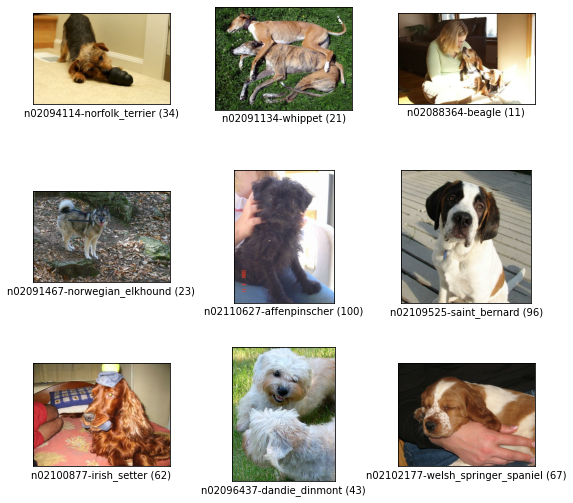

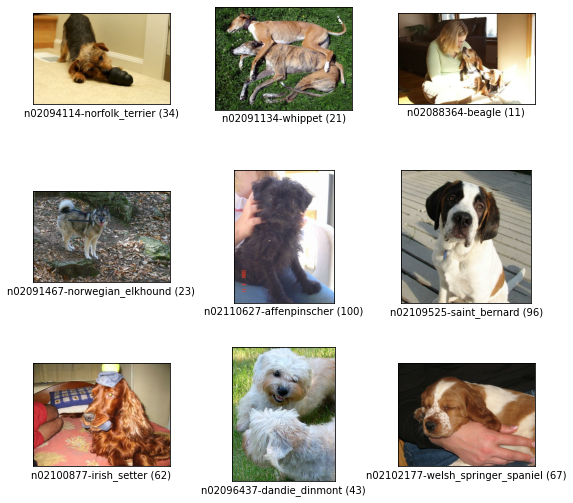

In [5]:
tfds.show_examples(ds_train, ds_info)

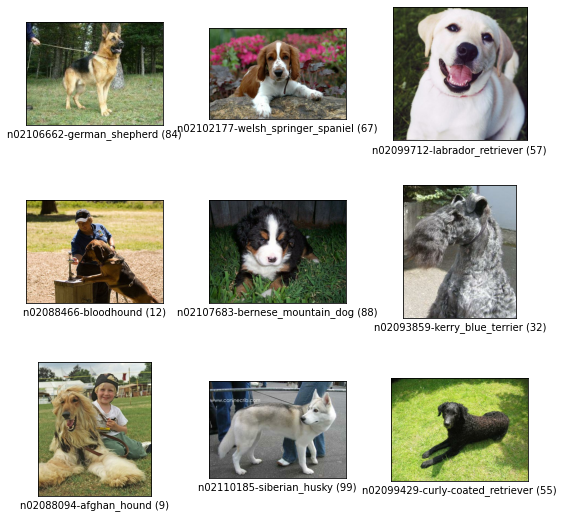

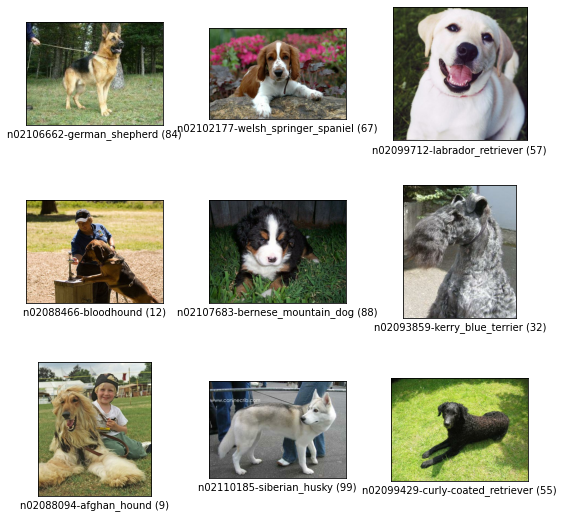

In [6]:
tfds.show_examples(ds_test, ds_info)

### 데이터 개수 확인

In [7]:
print('train :', tf.data.experimental.cardinality(ds_train))
print('test  :', tf.data.experimental.cardinality(ds_test))

train : tf.Tensor(12000, shape=(), dtype=int64)
test  : tf.Tensor(8580, shape=(), dtype=int64)


### 클래스

In [8]:
num_classes = ds_info.features["label"].num_classes

## Augmentation을 적용한 데이터셋 만들기

### 정규화 및 이미지 크기 변경 함수

In [9]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])          
    image = tf.cast(image, tf.float32) / 255.           # 0~1 사이의 float32로 정규화
    return image, label

### 원-핫 인코딩

In [10]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

### 좌우 대칭, 밝기 변경

In [11]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)            
    image = tf.image.random_brightness(image, max_delta=0.2)   
    image = tf.clip_by_value(image, 0, 1)
    return image, label

### 데이터셋에 augmentation 적용

In [12]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,   
        num_parallel_calls=2        
    )
    
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
        
    ds = ds.batch(batch_size)
    
    
    if not is_test and with_cutmix:      
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:     
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:                                
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

### Augmentation 적용, 비교실험

In [13]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                          split=['train', 'test'],
                                          as_supervised=True,
                                          shuffle_files=True,
                                          with_info=True,
                                         )

### Augmentation 적용 

In [14]:
ds_train_base_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=False, with_mixup=False)
# ds_test_base_aug = apply_normalize_on_dataset(ds_test,  with_aug=True, is_test=True)

### Augmentation 적용 X

In [15]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False,with_cutmix=False, with_mixup=False)
#ds_test_no_aug  = apply_normalize_on_dataset(ds_test,with_aug=False, is_test=True)

## CutMix

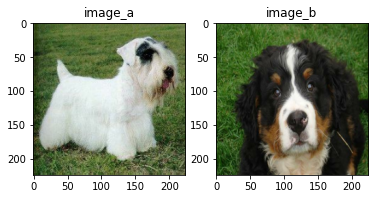

In [16]:
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):  
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.title("image_a")
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.title("image_b")
plt.imshow(image_b)

### 삽입될 영역 바운딩 박스 위치 결정 함수

In [17]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]   # width
    image_size_y = image_a.shape[0]   # height
    
    # get entire area of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width  = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)), tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_max = tf.math.maximum(0, x-width//2)        # get point starting in an area larger than 0       
    y_max = tf.math.maximum(0, y-height//2)              
    x_min = tf.math.minimum(image_size_x, x+width//2)   # get point ending in an area smaller than the image size
    y_min = tf.math.minimum(image_size_y, y+width//2)
    
    return x_max, y_max, x_min, y_min

x_max, y_max, x_min, y_min = get_clip_box(image_a, image_b)

### CutMix - 이미지 섞기

In [18]:
def mix_2_images(image_a, image_b, x_max, y_max, x_min, y_min):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    # combine areas divided into five parts
    middle_left = image_a[y_max:y_min,0:x_max,:]
    middle_center = image_b[y_max:y_min,x_max:x_min,:]
    middle_right = image_a[y_max:y_min,x_min:image_size_x,:]
    middle = tf.concat([middle_left,middle_center,middle_right],axis=1)
    
    top = image_a[0:y_max,:,:]
    bottom = image_a[y_min:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_max, y_max, x_min, y_min)

### 라벨 섞기

In [19]:
def mix_2_label(label_a, label_b, x_max, y_max, x_min, y_min, num_classes=120):
   
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    mixed_area = (x_min-x_max)*(y_min-y_max)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)    

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, x_max, y_max, x_min, y_min)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.565071  ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

### 배치 단위의 cutmix 함수

In [20]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)  # 0 =< j < 16
        image_b = image[j]  
        label_b = label[j]
    
        x_max, y_max, x_min, y_min = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_max, y_max, x_min, y_min))
        mixed_labels.append(mix_2_label(label_a, label_b, x_max, y_max, x_min, y_min))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

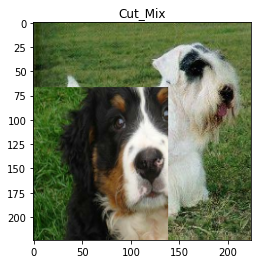

In [21]:
plt.title("Cut_Mix")
plt.imshow(mixed_img.numpy())

### CutMix Augmentation 적용 데이터셋

In [22]:
ds_train_cutmix_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True, with_mixup=False) 
#ds_test_cutmix_aug  = apply_normalize_on_dataset(ds_test,  with_cutmix=True, is_test=True)

### Mixup

In [23]:
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = tf.random.uniform([],0,1)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
        
    mixed_image = (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b, num_classes)

print(mixed_label)

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.565071   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.43492904 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

### 배치 단위의 mixup 함수

In [24]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b, num_classes)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

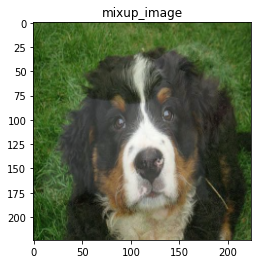

In [25]:
plt.title('mixup_image')
plt.imshow(mixed_img.numpy())

### Mixup Augmentation 적용 데이터셋

In [26]:
ds_train_mixup_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=False, with_mixup=True) 
# ds_test_mixup_aug  = apply_normalize_on_dataset(ds_test,  with_mixup=True, is_test=True)

# 모델 만들기

## ResNet-50

### Augmentation 적용하지 않은 ResNet

In [27]:
resnet50_no_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,    
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

### Augmentation 적용 ResNet

In [28]:
resnet50_base_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,    
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

### CutMix Augmentation 적용 ResNet

In [29]:
resnet50_cutmix_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,    
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

### Mixup Augmentation 적용 ResNet

In [30]:
resnet50_mixup_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,    
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

# 모델 훈련하기 >> categorical_crossentropy 사용

In [31]:
BATCH_SIZE = 16
EPOCH = 20

## Augmentation 적용 X 

In [32]:
resnet50_no_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [33]:
history_resnet50_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - ETA: 0s - loss: 2.2076 - accuracy: 0.4482

ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1330 test_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1320 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1313 run_step  **
        outputs = model.test_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1267 test_step
        y_pred = self(x, training=False)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer sequential: expected shape=(None, 224, 224, 3), found shape=(None, None, 3)


## 기본 Augmentation 적용

In [ ]:
resnet50_base_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [ ]:
history_resnet50_base_aug = resnet50_base_aug.fit(
    ds_train_base_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

## CutMix Augmentation

In [ ]:
resnet50_cutmix_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [ ]:
history_resnet50_cutmix_aug = resnet50_cutmix_aug.fit(
    ds_train_cutmix_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

## Mixup Augmentation

In [ ]:
resnet50_mixup_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [ ]:
history_resnet50_mixup_aug = resnet50_mixup_aug.fit(
    ds_train_mixup_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

- 원-핫 인코딩 >> https://deep-eye.tistory.com/67